# Homology recovery results

## Import libraries

In [1]:
import json
import os
from pathlib import Path
os.chdir(str(Path(os.getcwd()).parent))
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/tmp/ipykernel_2073121/2099343663.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Global plotting constants

In [2]:
SMALL_SIZE = 30
BIGGER_SIZE = 30
AXES_SIZE = 20
LEGEND_SIZE = 15
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=AXES_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=AXES_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=AXES_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=AXES_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=LEGEND_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("whitegrid", {"axes.grid": False})
plt.rcParams["axes.facecolor"] = "white"

## Construct table

In [5]:
mmseqs_output_df = pd.read_csv(
    "/data/jgut/template-analysis/PDB_70_CAMEO.tsv",
    sep="\t",
    names=["query", "hit", "identity", "coverage"],
)
identities_df = (
    mmseqs_output_df[
        (mmseqs_output_df.identity < 70)
        & (mmseqs_output_df.identity > 30)
        & (mmseqs_output_df.coverage > 0.8)
    ]
    .sort_values(["identity", "coverage"], ascending=[False, False])
    .groupby("query")
    .first()
)

output = []
for dataset in ["CAMEO1"]:
    dataset_path = Path(dataset)
    for template_path in dataset_path.glob("*.fasta"):
        template = template_path.stem
        methods = ["TEMPLATE_AF", "PDB70_AF", "PDB70"]
        for method in methods:
            if Path(f"{dataset_path}_{method}/{template}/ost_scores.json").exists():
                scores_path = Path(
                    f"{dataset_path}_{method}/{template}/ost_scores.json"
                )
            elif Path(f"{dataset_path}_{method}/{template}/scores.json").exists():
                scores_path = Path(f"{dataset_path}_{method}/{template}/scores.json")
            else:
                continue
            with open(scores_path, "r") as scores_file:
                curr_score = json.load(scores_file)
            if not ("tm_score" in curr_score):
                continue
            curr_output = {
                "dataset": dataset,
                "template": template,
                "method": method,
                "tm_score": curr_score["tm_score"],
                "rmsd": curr_score["rmsd"],
                "lddt": curr_score["lddt"],
                "bb_lddt": curr_score.get("bb_lddt", 0),
                "coverage": identities_df.loc[template]["coverage"]
                if template in identities_df.index.tolist()
                else 0,
                "identity": identities_df.loc[template]["identity"]
                if template in identities_df.index.tolist()
                else 0,
            }
            output.append(curr_output)
df = pd.DataFrame(output)
df

,dataset,template,method,tm_score,rmsd,lddt,bb_lddt,coverage,identity
0,CAMEO1,8VD6A,TEMPLATE_AF,0.914012,1.580065,0.763066,0.000000,0.000,0.0
1,CAMEO1,9CELD,TEMPLATE_AF,0.994377,0.475775,0.949870,0.000000,0.985,42.6
2,CAMEO1,9CELD,PDB70_AF,0.967505,1.227912,0.858303,0.911252,0.985,42.6
3,CAMEO1,9CELD,PDB70,0.923806,1.868137,0.594052,0.821213,0.985,42.6
4,CAMEO1,8WEUA,TEMPLATE_AF,0.998304,0.324594,0.962807,0.000000,0.996,37.5
...,...,...,...,...,...,...,...,...,...
110,CAMEO1,8RIUC,PDB70,0.855778,1.593940,0.526177,0.716056,0.983,45.6
111,CAMEO1,9AUEA,TEMPLATE_AF,0.999201,0.207595,0.976942,0.000000,0.957,34.5
112,CAMEO1,9AUEA,PDB70_AF,0.975039,1.428720,0.872878,0.922064,0.957,34.5
113,CAMEO1,9AUEA,PDB70,0.928635,2.289455,0.520740,0.773623,0.957,34.5


## Check if all setups are here

In [6]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
df.groupby(["method", "dataset"])["template"].agg("count")

method       dataset
PDB70        CAMEO1     31
PDB70_AF     CAMEO1     31
TEMPLATE_AF  CAMEO1     53
Name: template, dtype: int64

In [7]:
df.loc[df["template"].isin(df[df.method == "PDB70_AF"].template.unique()), :][ # PDB70_AF is taken as a minimal class
    ["method", "dataset", "tm_score", "rmsd", "lddt"]
].groupby(["method", "dataset"]).agg("mean")

,,tm_score,rmsd,lddt
method,dataset,,,
PDB70,CAMEO1,0.883993,3.803103,0.580791
PDB70_AF,CAMEO1,0.935142,2.575420,0.864652
TEMPLATE_AF,CAMEO1,0.979211,0.849158,0.954575


In [8]:
df.loc[df["template"].isin(df[df.method == "PDB70_AF"].template.unique()), :][ # PDB70_AF is taken as a minimal class
    ["template", "method", "dataset", "tm_score", "rmsd", "lddt"]
]

,template,method,dataset,tm_score,rmsd,lddt
1,9CELD,TEMPLATE_AF,CAMEO1,0.994377,0.475775,0.949870
2,9CELD,PDB70_AF,CAMEO1,0.967505,1.227912,0.858303
3,9CELD,PDB70,CAMEO1,0.923806,1.868137,0.594052
4,8WEUA,TEMPLATE_AF,CAMEO1,0.998304,0.324594,0.962807
5,8WEUA,PDB70_AF,CAMEO1,0.864178,5.134711,0.809135
6,8WEUA,PDB70,CAMEO1,0.853183,5.496964,0.510319
7,8VK9D,TEMPLATE_AF,CAMEO1,0.990768,0.318680,0.944688
8,8VK9D,PDB70_AF,CAMEO1,0.929412,1.531064,0.877919
9,8VK9D,PDB70,CAMEO1,0.800345,10.433753,0.599603
11,8WKCA,TEMPLATE_AF,CAMEO1,0.999228,0.226329,0.970900


### TM-score

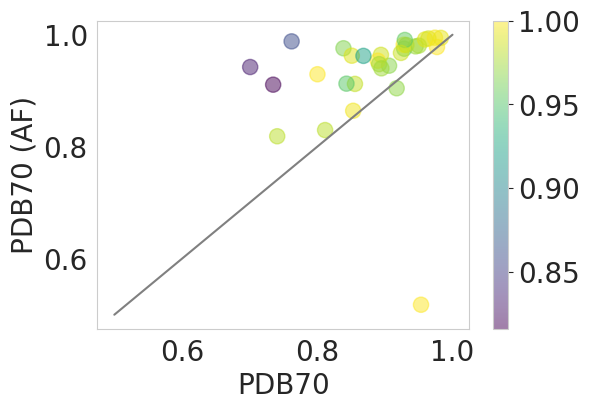

<Figure size 640x480 with 0 Axes>

In [9]:
indexed = df.set_index(["method", "template"])
fig, plt1 = plt.subplots(1, 1, sharey="row", figsize=(6, 4))
scat = plt1.scatter(
    [
        indexed.loc["PDB70", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["coverage"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
plt1.plot([0.5, 1], [0.5, 1], c="grey")
plt1.set_xlabel("PDB70")
plt1.set_ylabel("PDB70 (AF)")
plt.colorbar(scat)
plt.savefig(f"figures/PDB70.svg", bbox_inches="tight", transparent=True)
plt.show()
plt.clf()

### Backbone lDDT

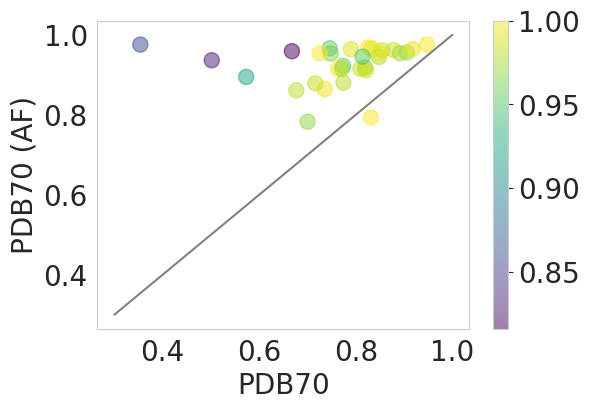

<Figure size 640x480 with 0 Axes>

In [10]:
indexed = df.set_index(["method", "template"])
fig, plt1 = plt.subplots(1, 1, sharey="row", figsize=(6, 4))
scat = plt1.scatter(
    [
        indexed.loc["PDB70", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["coverage"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
plt1.plot([0.3, 1], [0.3, 1], c="grey")
plt1.set_xlabel("PDB70")
plt1.set_ylabel("PDB70 (AF)")
plt.colorbar(scat)
plt.savefig(f"figures/PDB70.svg", bbox_inches="tight", transparent=True)
plt.show()
plt.clf()

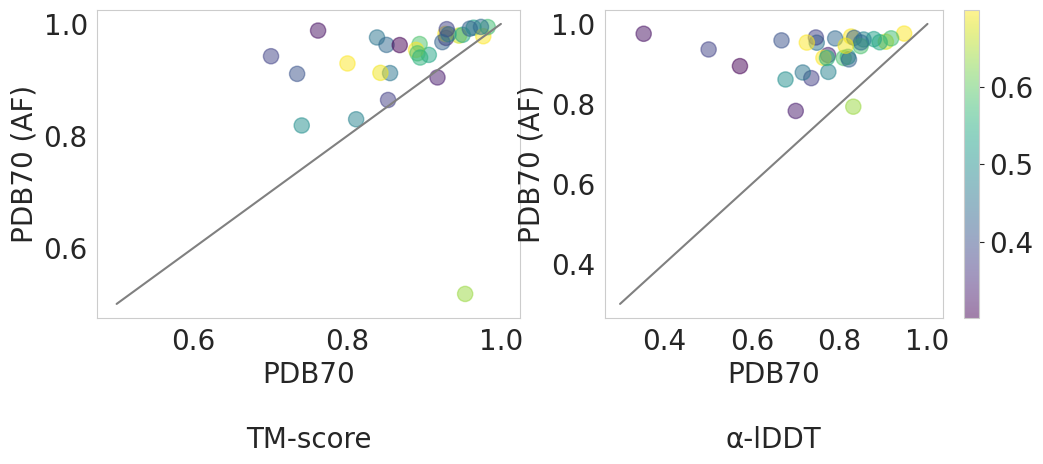

<Figure size 640x480 with 0 Axes>

In [11]:
indexed = df.set_index(["method", "template"])
fig, (tm_score, lddt) = plt.subplots(1, 2, figsize=(12, 4))

# fig, plt1 = plt.subplots(1, 1, sharey="row", figsize=(6, 4))
scat = tm_score.scatter(
    [
        indexed.loc["PDB70", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["identity"] / 100
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
tm_score.plot([0.5, 1], [0.5, 1], c="grey")
tm_score.set_xlabel("PDB70\n\nTM-score")
tm_score.set_ylabel("PDB70 (AF)")

scat = lddt.scatter(
    [
        indexed.loc["PDB70", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["identity"] / 100
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
lddt.plot([0.3, 1], [0.3, 1], c="grey")
lddt.set_xlabel("PDB70\n\nα-lDDT")
lddt.set_ylabel("PDB70 (AF)")

plt.colorbar(scat)
plt.savefig(f"figures/PDB70.svg", bbox_inches="tight", transparent=True)
plt.show()
plt.clf()

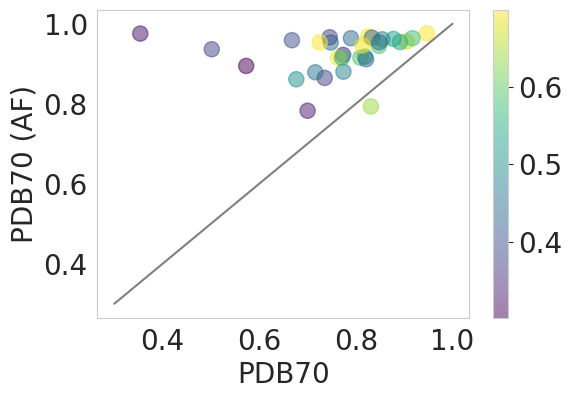

<Figure size 640x480 with 0 Axes>

In [12]:
indexed = df.set_index(["method", "template"])
fig, plt1 = plt.subplots(1, 1, sharey="row", figsize=(6, 4))
scat = plt1.scatter(
    [
        indexed.loc["PDB70", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["identity"] / 100
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
plt1.plot([0.3, 1], [0.3, 1], c="grey")
plt1.set_xlabel("PDB70")
plt1.set_ylabel("PDB70 (AF)")
plt.colorbar(scat)
plt.savefig(f"figures/PDB70.svg", bbox_inches="tight", transparent=True)
plt.show()
plt.clf()

## Table constants

In [13]:
# some variable names need to be changed
columns = [
    "TM-score $\\uparrow$",
    "lDDT $\\uparrow$",
    "$\\alpha$-RMSD ($\\AA$) $\\downarrow$",
]
measure_dict = {
    "lddt": "lDDT $\\uparrow$",
    "tm_score": "TM-score $\\uparrow$",
    "af_pLDDT_mean": "pLDDT $\\uparrow$",
    "rmsd": "$\\alpha$-RMSD ($\\AA$) $\\downarrow$",
    "method": "Method",
    "dataset": "Dataset",
}
method_dict = {
    "full": "MSA",
    "single": "Single",
    "NOISE": "Gaussian",
    "NOISE_AF": "Gaussian (AF)",
    "NOISE_OF_SS": "Gaussian (Rank Single)",
    "NOISE_OF_EMPTY": "Gaussian (Rank Empty)",
    "FLAT_1": "1 PC",
    "FLAT_1_AF": "1 PC (AF)",
    "FLAT_1_OF_SS": "1 PC (Rank Single)",
    "FLAT_1_OF_EMPTY": "1 PC (Rank Empty)",
    "FLAT_2": "2 PC",
    "FLAT_2_AF": "2 PC (AF)",
    "FLAT_2_OF_SS": "2 PC (Rank Single)",
    "FLAT_2_OF_EMPTY": "2 PC (Rank Empty)",
    "RF_1_ATTN": "1 RFDiff (AP)",
    "RF_1_ATTN_AF": "1 RFDiff (AP AF)",
    "RF_1_FASPR": "1 RFDiff (FASPR)",
    "RF_1_FASPR_AF": "1 RFDiff (FASPR AF)",
    "RF_1_OF_SS": "1 RFDiff (Rank Single)",
    "RF_1_OF_EMPTY": "1 RFDiff (Rank Empty)",
    "RF_5_ATTN": "5 RFDiff (AP)",
    "RF_5_ATTN_AF": "5 RFDiff (AP AF)",
    "RF_5_FASPR": "5 RFDiff (FASPR)",
    "RF_5_FASPR_AF": "5 RFDiff (FASPR AF)",
    "RF_5_OF_SS": "5 RFDiff (Rank Single)",
    "RF_5_OF_EMPTY": "5 RFDiff (Rank Empty)",
    "RF_10_ATTN": "10 RFDiff (AP)",
    "RF_10_ATTN_AF": "10 RFDiff (AP AF)",
    "RF_10_FASPR_AF": "10 RFDiff (FASPR AF)",
    "RF_10_FASPR": "10 RFDiff (FASPR)",
    "RF_10_OF_SS": "10 RFDiff (Rank Single)",
    "RF_10_OF_EMPTY": "10 RFDiff (Rank Empty)",
}

## Prepare DataFrame

In [14]:
df["type"] = df["method"].apply(
    lambda x: x[:-2] if x[-1].isnumeric() and len(x) > 6 else x
)
df["Method"] = df.rename(measure_dict, axis=1)["type"].replace(method_dict)
grouped = (
    df.drop("method", axis=1)
    .rename(measure_dict, axis=1)
    .sort_values("TM-score $\\uparrow$", ascending=False)
    .groupby(["Method", "template"])
    .agg("first")
    .groupby(["Method", "Dataset"])[columns]
    .agg("mean")
    .sort_values(["Method", "Dataset"])
)
grouped_std = (
    df.drop("method", axis=1)
    .rename(measure_dict, axis=1)
    .sort_values("TM-score $\\uparrow$", ascending=False)
    .groupby(["Method", "template"])
    .agg("first")
    .groupby(["Method", "Dataset"])[columns]
    .agg("std")
    .sort_values(["Method", "Dataset"])
)
for column in columns:
    grouped_std[f"{column}"] = (
        grouped[column].apply(lambda x: f"{x:.3f}")
        + "$\\pm$"
        + grouped_std[column].apply(lambda x: f"{x:.3f}")
    )
grouped_std

,,TM-score $\uparrow$,lDDT $\uparrow$,$\alpha$-RMSD ($\AA$) $\downarrow$
Method,Dataset,,,
PDB70,CAMEO1,0.884$\pm$0.076,0.581$\pm$0.116,3.803$\pm$3.548
PDB70_AF,CAMEO1,0.935$\pm$0.090,0.865$\pm$0.054,2.575$\pm$3.555
TEMPLATE_AF,CAMEO1,0.961$\pm$0.132,0.934$\pm$0.070,0.888$\pm$2.054


## Prepare DataFrame

In [16]:
rfdiff1 = df[df["method"].str.startswith("RF_1_FASPR")]
rfdiff10 = df[df["method"].str.startswith("RF_10_FASPR")]
grp_rdiff1 = (
    rfdiff1[rfdiff1["dataset"] == "CASP14"].groupby(["type", "template"]).agg("first")
)
grp_rdiff10 = (
    rfdiff10[rfdiff10["dataset"] == "CASP14"].groupby(["type", "template"]).agg("first")
)

## Plotting constants

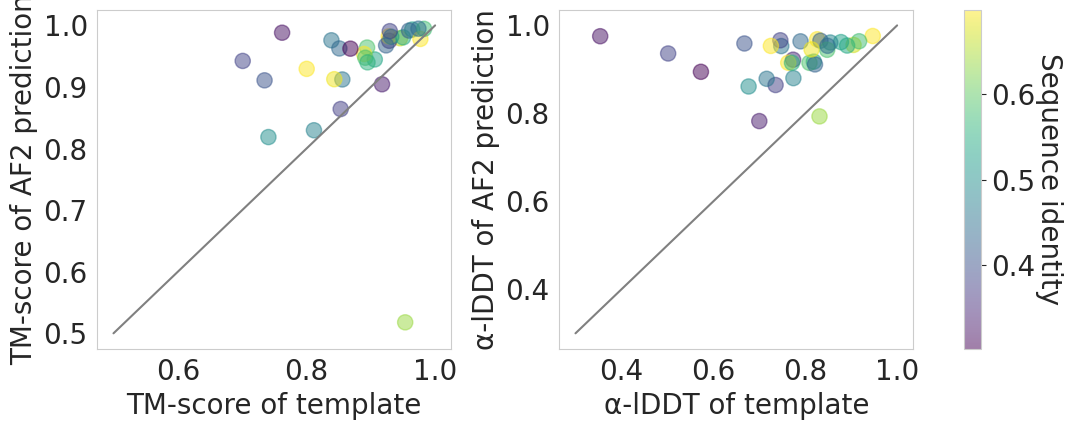

<Figure size 640x480 with 0 Axes>

In [17]:
indexed = df.set_index(["method", "template"])
fig, (tm_score, lddt) = plt.subplots(1, 2, figsize=(12, 5))
scat0 = tm_score.scatter(
    [
        indexed.loc["PDB70", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["tm_score"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["identity"] / 100
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
tm_score.plot([0.5, 1], [0.5, 1], c="grey")
tm_score.set_xlabel("TM-score of template")
tm_score.set_ylabel("TM-score of AF2 prediction")

scat1 = lddt.scatter(
    [
        indexed.loc["PDB70", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    [
        indexed.loc["PDB70_AF", template]["bb_lddt"]
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    s=120,
    alpha=0.5,
    c=[
        indexed.loc["PDB70_AF", template]["identity"] / 100
        for template in set(df[df.method == "PDB70_AF"].template.unique())
    ],
    cmap="viridis",
)
lddt.plot([0.3, 1], [0.3, 1], c="grey")
lddt.set_xlabel("α-lDDT of template")
lddt.set_ylabel("α-lDDT of AF2 prediction")
plt.tight_layout()
cbar = plt.colorbar(scat1, ax=[tm_score, lddt])
cbar.ax.set_ylabel("Sequence identity", labelpad=20, rotation=270)
plt.savefig(f"figures/PDB70.png", dpi=600, bbox_inches="tight", transparent=False)
plt.savefig(f"figures/PDB70.svg", bbox_inches="tight", transparent=True)
plt.show()
plt.clf()